In [ ]:
from dask.distributed import Client

client = Client("tcp://10.32.5.18:44495")
client

# SOSE HEAT BUDGET

(isel not sel)

In [122]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake

In [35]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["SOSE"].to_dask()

In [36]:
coordsr = ds.coords.to_dataset().reset_coords() #ds split into coords
dsr = ds.reset_coords(drop=True) #ds dropping coords so it just holds data variables
dsr

,Array,Chunk
Bytes,47.37 GiB,110.74 MiB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,2 Graph Layers,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,47.37 GiB,110.74 MiB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,2 Graph Layers,438 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## New northern boundary | Visualize the ACC region you're going to ignore

In [46]:
#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
#WG model's boundaries (-77.87497˚S, -57.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0 #-77.87497
upper_lat = 125 #-57.041634
left_lon =  310 #51.75
right_lon = 880 #146.75

#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

coords = coordsr.roll(XC=700, roll_coords=True).isel(**lat_range, **lon_range)
ds = dsr.roll(XC=700, roll_coords=True).isel(**lat_range, **lon_range)

In [47]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [115]:
temp = ds.THETA.drop('XC')[0,0]
mask = coords.drop('XC').hFacC[0] > 0

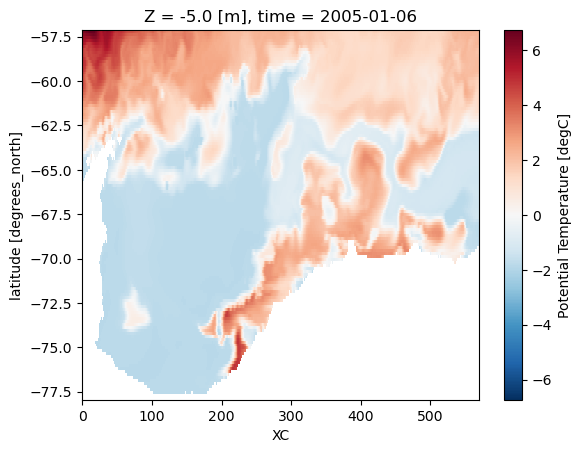

In [68]:
temp.where(mask).plot();

In [118]:
#mask out the acc in the corner
mask = xr.ones_like(temp)

mask[88:None, None:57] = 0
mask[77:88, None:36] = 0
mask[73:77, None:5] = 0

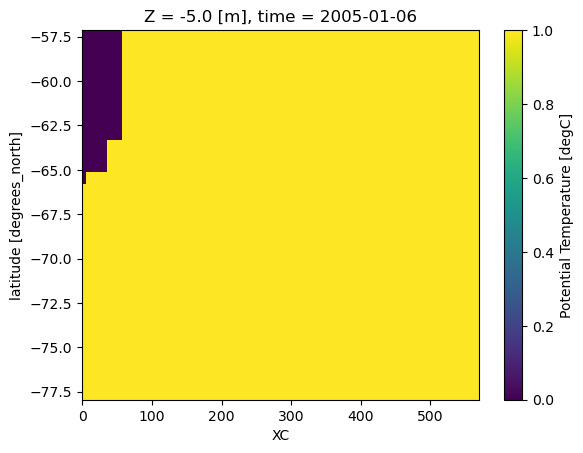

In [119]:
mask.plot();

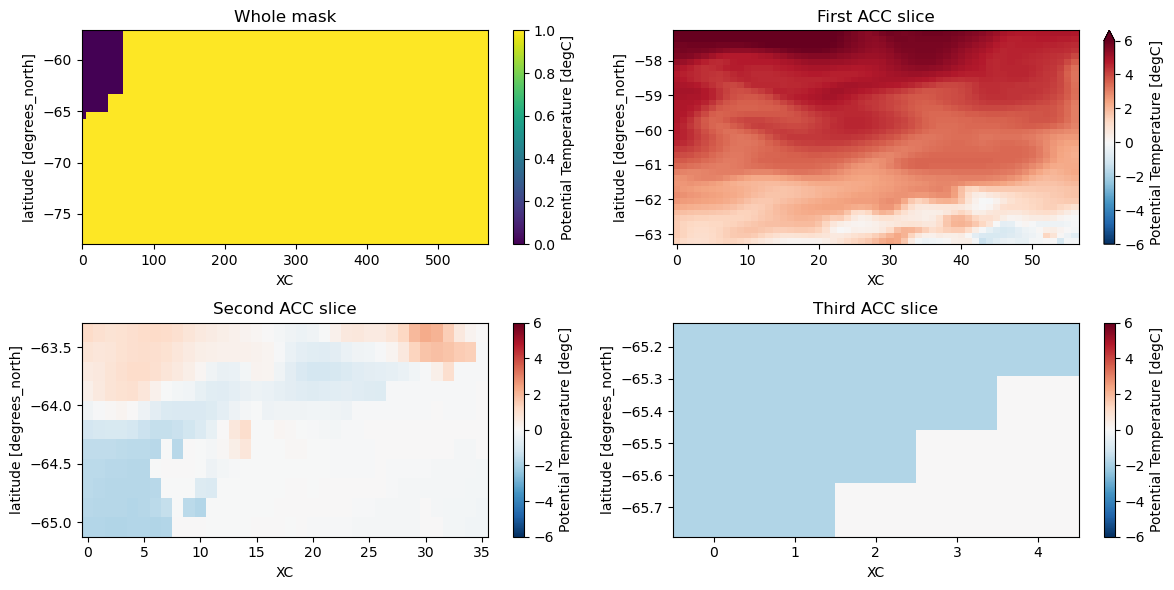

In [121]:
#visualize the 3 masks
fig, ax = plt.subplots(2,2, figsize=(12,6))

mask.plot(ax=ax[0,0])
ax[0,0].set_title('Whole mask')
temp[88:None, None:57].plot(ax=ax[0,1], cmap='RdBu_r', vmin=-6, vmax=6)
ax[0,1].set_title('First ACC slice')
temp[77:88, None:36].plot(ax=ax[1,0], cmap='RdBu_r', vmin=-6, vmax=6)
ax[1,0].set_title('Second ACC slice')
temp[73:77, None:5].plot(ax=ax[1,1], cmap='RdBu_r', vmin=-6, vmax=6)
ax[1,1].set_title('Third ACC slice')

plt.tight_layout();

In [19]:
# Given upper right / lower left cell coordinates, construct the tx_trans and ty_trans sections that bound it

def box_budget(ds0, left_i, right_i, lower_j, upper_j,):
    """Function to compute box budget given any set of boundaries"""

    ty_upper = ds0.ty_int.isel(xt_ocean=slice(left_i, right_i+1), yu_ocean=upper_j)
    ty_lower = ds0.ty_int.isel(xt_ocean=slice(left_i, right_i+1), yu_ocean=lower_j-1)
    tx_right = ds0.tx_int.isel(xu_ocean=right_i, yt_ocean=slice(lower_j, upper_j+1))
    tx_left = ds0.tx_int.isel(xu_ocean=left_i-1, yt_ocean=slice(lower_j, upper_j+1))
    
    return -ty_upper.sum().values + ty_lower.sum().values - tx_right.sum().values + tx_left.sum().values

In [23]:
box1 = box_budget(transport_trunc,  41, 380, 159, 207)
box2 = box_budget(transport_trunc, 30, 380, 149, 159)
box3 = box_budget(transport_trunc, 16, 380, 123, 149)
box4 = box_budget(transport_trunc, 1, 380, 1, 123)

residual = box1 + box2 + box3 + box4
residual

-0.0086315945

## Heat budget for WG (entire water column)

In [7]:
dsr.Z[0]

<xarray.DataArray 'Z' ()>
array(-5., dtype=float32)
Coordinates:
    Z        float32 -5.0
Attributes:
    axis:           Z
    long_name:      vertical coordinate of cell center
    positive:       down
    standard_name:  depth
    units:          m

In [8]:
sst_mean = dsr.THETA.isel(Z=0).mean(dim='time').load()

In [9]:
surface_mask = (coords.hFacC[0]>0).load()

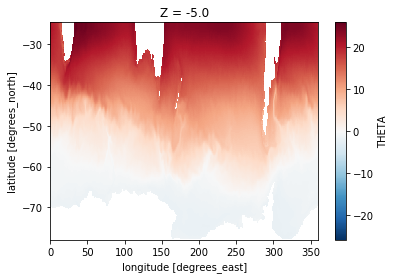

In [10]:
sst_mean.where(surface_mask).plot()

In [11]:
left_lon = 298
upper_lat = -65
right_lon = 360
lower_lat = -78

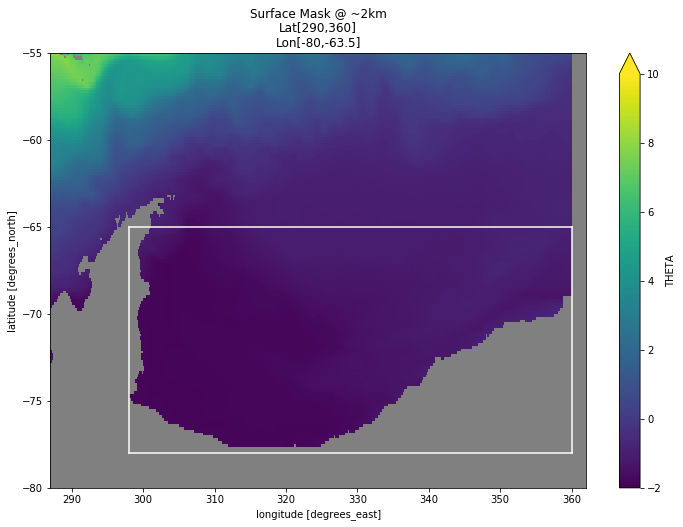

In [12]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'facecolor': '0.5'})
(sst_mean.where(surface_mask)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Surface Mask @ ~2km\nLat[290,360]\nLon[-80,-63.5]');

In [13]:
lower_lat = 0
upper_lat = 78
left_lon = 1788
right_lon = 2159

In [14]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [15]:
#advective flux
adv_flux_y = dsr.ADVy_TH.isel(**lon_range, YG=upper_lat).sum(dim=['XC', 'Z']).load()
adv_flux_x = dsr.ADVx_TH.isel(**lat_range, XG=right_lon).sum(dim=['YC', 'Z']).load()

adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-13177336. , -13868049. , -15939710. , -15945996. , -13535516. ,
       -12383381. , -17896574. , -16720998. , -16224325. , -15063235. ,
       -14599633. , -18370340. , -18280516. , -18468040. , -18300840. ,
       -16576600. , -12112752. , -13493427. , -14502603. , -14908526. ,
       -17495518. , -13772225. , -14761115. , -14332600. , -13986804. ,
       -13665727. ,  -9589162. , -11800888. , -13229797. , -14437546. ,
       -10228169. , -10369114. , -10883145. , -10560693. , -11261402. ,
       -11236859. , -10275419. , -11042017. , -11586392. , -10250246. ,
        -9994532. ,  -8711900. , -11034044. ,  -9725865. , -10041669. ,
       -10059365. ,  -7425538.5,  -9431740. ,  -9580468. ,  -8939412. ,
       -10688761. , -10717335. ,  -8664674. ,  -7257569. ,  -7781329. ,
        -9073374. ,  -6144029. ,  -5750700.5,  -7726900. ,  -7765789.5,
        -9716435. ,  -9640049. ,  -9773838. ,  -9848085. ,  -8217152. ,
        -7558530. ,  -6430498. , 

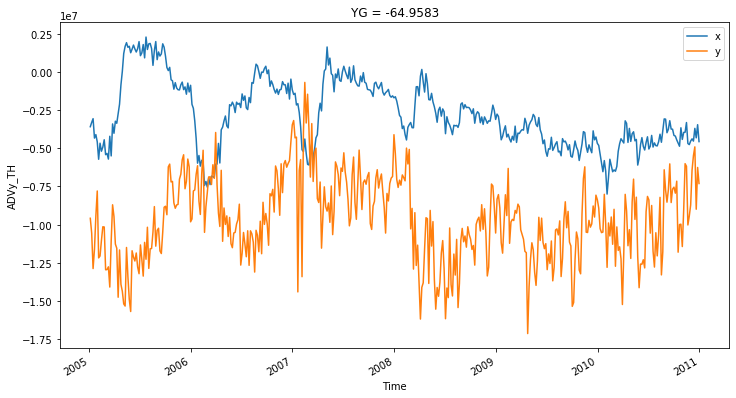

In [16]:
plt.figure(figsize=(12,6))

adv_flux_x.plot(label='x')
adv_flux_y.plot(label='y')
plt.legend()

In [17]:
#diffusive flux
diff_flux_y = dsr.DFyE_TH.isel(**lon_range, YG=upper_lat).sum(dim=['XC', 'Z']).load()
diff_flux_x = dsr.DFxE_TH.isel(**lat_range, XG=right_lon).sum(dim=['YC', 'Z']).load()

diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-7.73863086e+03, -1.39088779e+04, -6.38365430e+03,  1.32257363e+04,
        5.60935059e+03,  2.36007520e+03, -4.06545898e+03,  2.82727832e+03,
        3.67792969e+01,  1.37264434e+04,  1.95332266e+04,  1.37609062e+04,
        1.47119062e+04,  1.45210518e+04,  4.73180859e+03,  1.13997607e+03,
        7.57407275e+03, -1.08574668e+04, -5.85610840e+03, -3.66938574e+03,
       -1.48499834e+04,  5.99973340e+03,  7.08710059e+03,  5.73988428e+03,
       -4.72769873e+03, -5.40050293e+03,  4.35272949e+03,  7.90080811e+02,
        8.70478516e+01, -6.48625195e+03,  1.37450020e+04, -3.69096875e+03,
        1.13492871e+03,  1.92568906e+04, -1.76444023e+04, -2.64357168e+04,
       -8.26728516e+03,  5.26916562e+04,  8.70800547e+04,  1.46245969e+05,
        1.43946891e+05,  1.46854938e+05,  6.78983438e+04, -6.07812500e+03,
        7.76356055e+03, -4.67754961e+04, -9.86554844e+04, -1.10185766e+05,
       -3.26828887e+04,  8.31046484e+04,  1.22143250e+05,  1.36761938

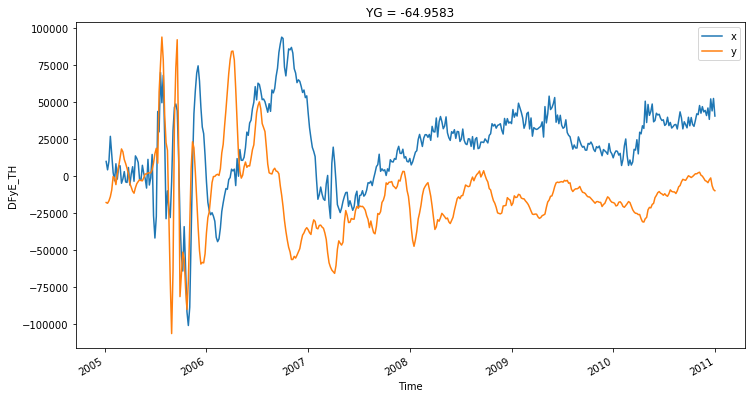

In [18]:
plt.figure(figsize=(12,6))
diff_flux_x.plot(label='x')
diff_flux_y.plot(label='y')
plt.legend()

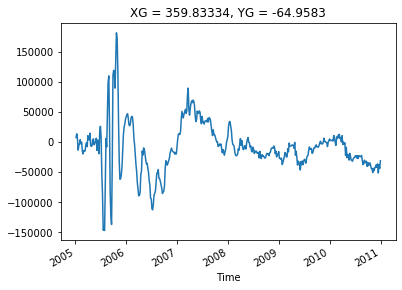

In [23]:
(-diff_flux).plot()

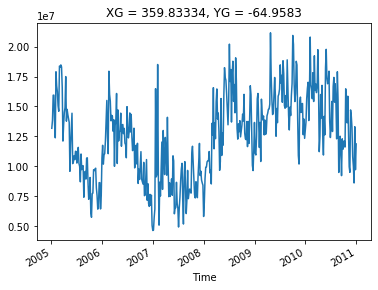

In [24]:
(-adv_flux).plot()

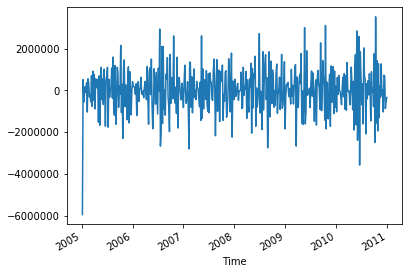

In [27]:
lin_fs_correction.plot()

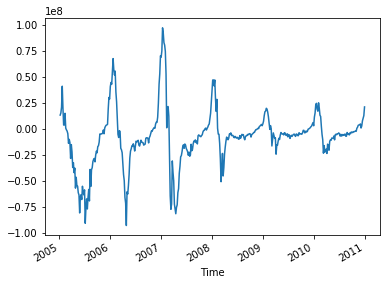

In [28]:
surface_term.plot()

In [25]:
#vertical flux
t_flux_z = (dsr.TFLUX.isel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC'])
t_flux_z.load()
#units: W = (kg*m^2)/s^3

<xarray.DataArray (time: 438)>
array([ 5.42072688e+13,  6.27375562e+13,  8.60377412e+13,  1.68997803e+14,
        8.09222841e+13,  1.46125567e+13,  1.50960110e+13,  6.13848554e+13,
        2.32108170e+12, -4.33712949e+12, -9.46499643e+12, -1.97307757e+13,
       -5.79572450e+13, -4.20535851e+13, -5.49597731e+13, -1.17920542e+14,
       -6.29654537e+13, -9.23824145e+13, -1.54089065e+14, -1.34892885e+14,
       -1.74388977e+14, -1.56381320e+14, -2.35883396e+14, -1.92815057e+14,
       -2.26055068e+14, -2.27669573e+14, -2.54281240e+14, -2.62902028e+14,
       -3.34511615e+14, -2.69507705e+14, -2.62186144e+14, -2.81172366e+14,
       -2.28545830e+14, -2.53588308e+14, -2.62688354e+14, -2.42899258e+14,
       -3.75590461e+14, -3.13880371e+14, -2.78742589e+14, -3.18806765e+14,
       -2.72675360e+14, -2.41243750e+14, -2.86859423e+14, -1.61538032e+14,
       -2.29095619e+14, -1.62631285e+14, -1.54636456e+14, -1.30414123e+14,
       -1.21917705e+14, -1.18025836e+14, -1.31532904e+14, -1.04448001

In [26]:
#linear free surface correction
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3
surface_term = t_flux_z / (heat_capacity_cp * runit2mass)
#units: (˚C m^3)/s

lin_fs_correction = -(dsr.WTHMASS.isel(Zl=0, drop=True) * coords.rA
                     ).isel(**lat_range, **lon_range).sum(dim=['XC', 'YC'])
#i noticed lin_fs_corr term didn't have `**lon_range` - should it not have?
#units: (˚C m^3)/s

In [20]:
surface_term.load()

<xarray.DataArray (time: 438)>
array([ 1.31132130e+07,  1.51767640e+07,  2.08132840e+07,  4.08820480e+07,
        1.95758100e+07,  3.53490550e+06,  3.65185725e+06,  1.48495340e+07,
        5.61490000e+05, -1.04918962e+06, -2.28966550e+06, -4.77304750e+06,
       -1.40203650e+07, -1.01731300e+07, -1.32952500e+07, -2.85260120e+07,
       -1.52318950e+07, -2.23481160e+07, -3.72754960e+07, -3.26317700e+07,
       -4.21862200e+07, -3.78300120e+07, -5.70622600e+07, -4.66436520e+07,
       -5.46847000e+07, -5.50752640e+07, -6.15128600e+07, -6.35983040e+07,
       -8.09212880e+07, -6.51962720e+07, -6.34251240e+07, -6.80180560e+07,
       -5.52872360e+07, -6.13452320e+07, -6.35466120e+07, -5.87594560e+07,
       -9.08586240e+07, -7.59304080e+07, -6.74302720e+07, -7.71221520e+07,
       -6.59625560e+07, -5.83589760e+07, -6.93938080e+07, -3.90774640e+07,
       -5.54202360e+07, -3.93419320e+07, -3.74079120e+07, -3.15483180e+07,
       -2.94929600e+07, -2.85514840e+07, -3.18189620e+07, -2.52668860

In [21]:
lin_fs_correction.load()

<xarray.DataArray (time: 438)>
array([-5.95137050e+06,  5.11134188e+05, -5.64776125e+05,  1.22655062e+05,
        1.70362016e+05, -1.25062766e+05,  3.57015938e+05, -1.04294150e+06,
        5.50052000e+05,  3.62431500e+05, -3.10153875e+05, -2.35253438e+05,
       -5.58960062e+05,  6.92226875e+05, -7.76458562e+05,  9.12190500e+05,
       -4.94520750e+05,  7.57844375e+05, -8.94319250e+05,  5.50398250e+05,
        5.10189500e+05,  1.15889289e+05,  5.16637969e+05, -1.52751075e+06,
        6.90480688e+05, -1.67595425e+06, -1.25286688e+05,  1.10171112e+06,
       -4.46353969e+05,  5.36406062e+05, -6.80821938e+05,  1.01026344e+06,
        2.43490891e+05, -1.71844188e+06,  4.39297875e+05,  7.10136125e+05,
        1.09989450e+06, -1.76623550e+06,  5.24580125e+05, -3.28460406e+05,
        4.34983125e+04,  1.39310797e+05,  1.06525312e+06, -3.76927875e+05,
        1.59398550e+06, -9.99997375e+05, -1.19500012e+06,  1.18649538e+06,
       -1.63170850e+06, -8.71217875e+05,  1.10088825e+06,  8.55605375

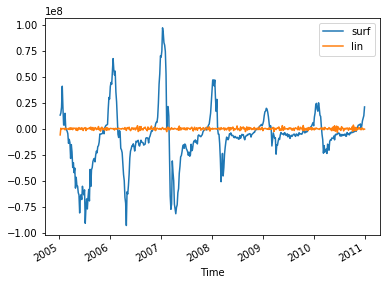

In [22]:
surface_term.plot(label='surf')
lin_fs_correction.plot(label='lin')
plt.legend()

In [23]:
tottend_weddell = (dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC).isel(
                          **lon_range, **lat_range).sum(dim=['XC', 'YC', 'Z']) / (24*60*60)
tottend_weddell.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([ 2.03469134e+07,  2.95698584e+07,  3.61946074e+07,  5.69374948e+07,
        3.32760891e+07,  1.57908613e+07,  2.19095146e+07,  3.05247604e+07,
        1.73358361e+07,  1.43627484e+07,  1.19802819e+07,  1.33482739e+07,
        3.68648002e+06,  8.97261340e+06,  4.22439633e+06, -1.10383665e+07,
       -3.62123681e+06, -8.08598263e+06, -2.36613495e+07, -1.71691789e+07,
       -2.41656673e+07, -2.39478951e+07, -4.17915942e+07, -3.38443135e+07,
       -4.00026859e+07, -4.30800926e+07, -5.20533576e+07, -5.06964954e+07,
       -6.81379309e+07, -5.02158374e+07, -5.38915210e+07, -5.66349915e+07,
       -4.41617188e+07, -5.25222131e+07, -5.18282354e+07, -4.67860351e+07,
       -7.94750521e+07, -6.67073346e+07, -5.54063918e+07, -6.73466080e+07,
       -5.60684571e+07, -4.96546156e+07, -5.73624108e+07, -2.97224511e+07,
       -4.37923506e+07, -3.02357861e+07, -3.10787246e+07, -2.08198997e+07,
       -2.15115124e+07, -2.05663877e+07, -2.01514553e+07, -1.38307068

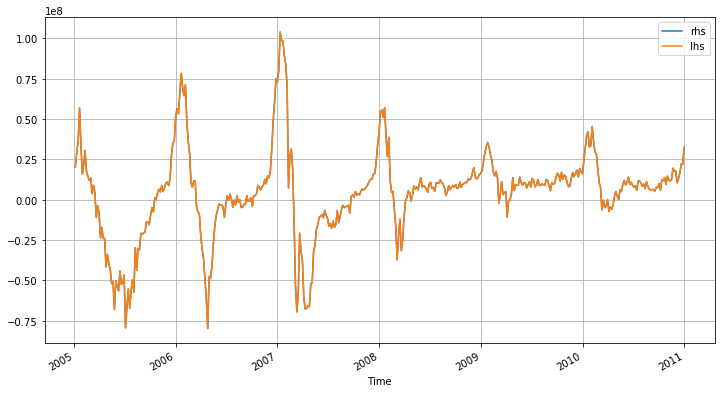

In [24]:
rhs = - adv_flux - diff_flux + lin_fs_correction + surface_term
lhs = tottend_weddell

plt.figure(figsize=(12,6))
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend()
plt.grid();

In [ ]:
all_terms = xr.merge([tottend_weddell.rename('tottend'),
                      -adv_flux.rename('adv_flux'),
                      -diff_flux.rename('diff_flux'),
                      lin_fs_correction.rename('lin_fs'),
                      surface_term.rename('surface')])
all_terms

In [ ]:
plt.figure(figsize=(12,6))
all_terms.to_array().plot.line(x='time')

In [ ]:
df = all_terms.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df

In [ ]:
df.plot(figsize=(12,6), kind='bar')
plt.grid();

In [ ]:
adv_flux_clim = (adv_flux.groupby('time.month') 
                    - adv_flux.groupby('time.month').mean(dim='time'))
diff_flux_clim = (diff_flux.groupby('time.month') 
                      - diff_flux.groupby('time.month').mean(dim='time'))
surf_term_clim = (surface_term.groupby('time.month')
                  - surface_term.groupby('time.month').mean(dim='time'))
lin_fs_correction_clim = (lin_fs_correction.groupby('time.month') -
                          lin_fs_correction.groupby('time.month').mean(dim='time'))
tottend_weddell_clim = (tottend_weddell.groupby('time.month') 
                            - tottend_weddell.groupby('time.month').mean(dim='time'))

In [ ]:
all_terms_clim = xr.merge([-adv_flux_clim.rename('adv_flux'), 
                            -diff_flux_clim.rename('diff_flux'),
                            surf_term_clim.rename('surf_term'),
                            lin_fs_correction_clim.rename('lin_fs_corr'),
                            tottend_weddell_clim.rename('tottend')])
all_terms_clim

In [ ]:
plt.figure(figsize=(12,6))
all_terms_clim.to_array().plot.line(x='time')
plt.grid()
plt.title('Interannual Variability\nWG entire column');

In [ ]:
cov_adv = (np.cov(tottend_weddell_clim, -adv_flux_clim) / 
           np.cov(tottend_weddell_clim, tottend_weddell_clim))
cov_diff = (np.cov(tottend_weddell_clim, -diff_flux_clim) / 
            np.cov(tottend_weddell_clim, tottend_weddell_clim))
cov_surf = (np.cov(tottend_weddell_clim, surf_term_clim) / 
            np.cov(tottend_weddell_clim, tottend_weddell_clim))
cov_lin_fs = (np.cov(tottend_weddell_clim, lin_fs_correction_clim) / 
            np.cov(tottend_weddell_clim, tottend_weddell_clim))
cov_tottend = (np.cov(tottend_weddell_clim, tottend_weddell_clim) /
               np.cov(tottend_weddell_clim, tottend_weddell_clim))

In [ ]:
cov_array = np.array([cov_adv[1,0], cov_diff[1,0], cov_surf[1,0], cov_lin_fs[1,0], cov_tottend[1,0]])
cov_array

In [ ]:
cov_array_terms = np.array(['adv', 'diff', 'surf', 'lin_fs_corr', 'tottend'])

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(cov_array_terms, cov_array)
plt.grid()
plt.title('Covariance');

## Heat budget for Lower WG (-2,046m to bottom)

In [ ]:
left_lon = 299
upper_lat = -66
right_lon = 360
lower_lat = -78

In [ ]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'facecolor': '0.5'})
(sst_mean_lower.where(surface_mask_lower)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Lower Surface Mask @ ~2046m\nLon[299,360]\nLat[-78,-66]');

In [ ]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 0
upper_lat_lower = 71
left_lon_lower = 1794
right_lon_lower = 2159

lower_cell_range = dict(Zl=[27, 42])
lower_cell_range_z = dict(Z=slice(27, 42))

In [ ]:
#set the boundaries
lat_range_lower = dict(YC=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(XC=slice(left_lon_lower, right_lon_lower))

In [ ]:
#advective flux
adv_flux_y_lower = dsr.ADVy_TH.isel(**lon_range_lower, YG=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                              dim=['XC','Z']).load()
adv_flux_x_lower = dsr.ADVx_TH.isel(**lat_range_lower, XG=right_lon_lower, **lower_cell_range_z).sum(
                                                                                              dim=['YC','Z']).load()
adv_flux_z_lower = dsr.ADVr_TH.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC']).load()

adv_flux_lower = adv_flux_x_lower + adv_flux_y_lower + adv_flux_z_lower
adv_flux_lower.load()
#units: (˚C m^3)/s

In [ ]:
plt.figure(figsize=(12,6))
adv_flux_x_lower.plot(label='x')
adv_flux_y_lower.plot(label='y')
adv_flux_z_lower.plot(label='z')
plt.legend();

In [ ]:
#diffusive flux
diff_flux_y_lower = dsr.DFyE_TH.isel(**lon_range_lower, YG=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                dim=['XC','Z']).load()
diff_flux_x_lower = dsr.DFxE_TH.isel(**lat_range_lower, XG=right_lon_lower, **lower_cell_range_z).sum(
                                                                                dim=['YC','Z']).load()
diff_flux_z_lower =  ((dsr.DFrE_TH.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                     + dsr.DFrI_TH.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                     + dsr.KPPg_TH.isel(**lon_range_lower, **lat_range_lower, Zl=27).sum(dim=['XC', 'YC'])
                                                                                                 ).load())

diff_flux_lower = diff_flux_x_lower + diff_flux_y_lower + diff_flux_z_lower
diff_flux_lower.load()
#units: (˚C m^3)/s

In [ ]:
plt.figure(figsize=(12,6))
diff_flux_x_lower.plot(label='x')
diff_flux_y_lower.plot(label='y')
diff_flux_z_lower.plot(label='z')
plt.legend()

In [ ]:
tottend_weddell_lower = ((dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC).isel(
                         **lon_range_lower, **lat_range_lower, **lower_cell_range_z).sum(
                                                                    dim=['XC', 'YC','Z'])) / (24*60*60)
tottend_weddell_lower.load()
#units: (˚C m^3)/s

In [ ]:
plt.figure(figsize=(12,6))
rhs_lower = - adv_flux_lower - diff_flux_lower
lhs_lower = tottend_weddell_lower
rhs_lower.plot(label='rhs_lower')
lhs_lower.plot(label='lhs_lower')
plt.legend()
plt.grid();

In [ ]:
all_terms_lower = xr.merge([-adv_flux_lower.rename('adv_flux'), 
                            -diff_flux_lower.rename('diff_flux'),
                            tottend_weddell_lower.rename('tottend')])
all_terms_lower

In [ ]:
plt.figure(figsize=(12,6))
all_terms_lower.to_array().plot.line(x='time')
plt.grid();

In [ ]:
df_lower = all_terms_lower.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df_lower

In [ ]:
df_lower.plot(figsize=(12,6), kind='bar')
plt.grid()

In [ ]:
(rhs_lower - lhs_lower).plot(figsize=(12,6))
plt.grid();

In [ ]:
adv_flux_lower_clim = (adv_flux_lower.groupby('time.month') 
                    - adv_flux_lower.groupby('time.month').mean(dim='time'))
diff_flux_lower_clim = (diff_flux_lower.groupby('time.month') 
                      - diff_flux_lower.groupby('time.month').mean(dim='time'))
tottend_weddell_lower_clim = (tottend_weddell_lower.groupby('time.month') 
                            - tottend_weddell_lower.groupby('time.month').mean(dim='time'))

In [ ]:
all_terms_lower_clim = xr.merge([-adv_flux_lower_clim.rename('adv_flux'), 
                            -diff_flux_lower_clim.rename('diff_flux'),
                            tottend_weddell_lower_clim.rename('tottend')])
all_terms_lower_clim

In [ ]:
plt.figure(figsize=(12,6))
all_terms_lower_clim.to_array().plot.line(x='time')
plt.grid()
plt.title('Interannual Variability\nWG lower column');

In [ ]:
cov_adv_lower = (np.cov(tottend_weddell_lower_clim, -adv_flux_lower_clim) / 
           np.cov(tottend_weddell_lower_clim, tottend_weddell_lower_clim))
cov_diff_lower = (np.cov(tottend_weddell_clim, -diff_flux_lower_clim) / 
            np.cov(tottend_weddell_lower_clim, tottend_weddell_lower_clim))
cov_tottend_lower = (np.cov(tottend_weddell_lower_clim, tottend_weddell_lower_clim) /
               np.cov(tottend_weddell_lower_clim, tottend_weddell_lower_clim))

In [ ]:
cov_adv_lower

In [ ]:
cov_diff_lower

In [ ]:
cov_tottend_lower

In [ ]:
cov_array_lower = np.array([cov_adv_lower[1,0], cov_diff_lower[1,0], cov_tottend_lower[1,0]])
cov_array_lower

In [ ]:
cov_array_terms_lower = np.array(['adv_lower', 'diff_lower', 'tottend_lower'])

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(cov_array_terms_lower, cov_array_lower)
plt.grid()
plt.title('Covariance');